In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def MC_Asian(S0, dividends, vols, K, r, T, num_paths, seed=100):
    """
    Price an Asian basket option using Monte Carlo simulation.

    Parameters
    ----------
    S0 : array_like
        Initial spot prices for each asset of shape (N,).
    dividends : array_like
        Continuous dividend yields for each asset of shape (N,).
    vols : array_like
        Volatility segments for each asset over time, of shape (N, M).
        Each row corresponds to one asset, and each column to a time segment.
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    T : float
        Time to maturity (in years).
    num_paths : int
        Number of Monte Carlo paths to simulate.
    seed : int, optional
        Seed for the random number generator, default is 100.

    Returns
    -------
    price : float
        The estimated option price.
    std_error : float
        The standard error of the estimate.
    """
    np.random.seed(seed)
    
    N = len(S0)       
    M = vols.shape[1] 
    dt = T / M         
    Z = np.random.normal(size=(num_paths, N, M))  
    
    # Initialize price array: shape (num_paths, N, M+1)
    S = np.zeros((num_paths, N, M + 1))
    S[:, :, 0] = S0  # Set initial prices for all paths and all assets

    # Simulate the price paths under the risk-neutral measure
    for m in range(1, M + 1):
        vol_segment = vols[:, m - 1]
        drift = (r - dividends - 0.5 * vol_segment**2) * dt
        diffusion = vol_segment * np.sqrt(dt) * Z[:, :, m - 1]
        S[:, :, m] = S[:, :, m - 1] * np.exp(drift + diffusion)

    # Compute normalized basket values at each observation time
    # Normalization: S_i(T_m)/S_i(T_0)
    normalized_prices = S[:, :, 1:] / S[:, :, [0]]  
    
    # Basket at each observation date: average over assets
    # B(T_m) = (1/N) * Σ_i [S_i(T_m)/S_i(T_0)]
    B_TM = np.mean(normalized_prices, axis=1)  
    
    # Asian basket at maturity is the average over the M observation points
    # Asian_Basket(T_M) = (1/M)*Σ_m B(T_m)
    basket_values = np.mean(B_TM, axis=1)  

    # Payoff: max(Asian_Basket(T_M) - K, 0)
    payoffs = np.maximum(basket_values - K, 0)

    # Discount payoffs back to time 0
    discount_factor = np.exp(-r * T)
    price = discount_factor * np.mean(payoffs)
    std_error = discount_factor * np.std(payoffs) / np.sqrt(num_paths)

    return price, std_error


def FDM(S0, dividends, vols, K, r, T, num_paths, eps):
    """
    Compute option price and finite difference sensitivities.

    Parameters
    ----------
    S0 : array_like
        Initial spot prices for each asset (N,).
    dividends : array_like
        Continuous dividend yields for each asset (N,).
    vols : array_like
        Volatility segments for each asset (N, M).
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    T : float
        Time to maturity.
    num_paths : int
        Number of Monte Carlo paths.
    eps : float
        Perturbation step used in finite difference calculations.

    Returns
    -------
    base_price : float
        The base option price before perturbations.
    S0_sensi : list of float
        Sensitivities w.r.t. initial spot prices (N elements).
    dividends_sensi : list of float
        Sensitivities w.r.t. dividends (N elements).
    vols_sensi : list of list of float
        Sensitivities w.r.t. volatilities (N x M).
    """
    N, M = len(S0), vols.shape[1]
    
    # Compute base price
    base_price, _ = MC_Asian(S0, dividends, vols, K, r, T, num_paths)

    # Sensitivities with respect to initial prices S0
    S0_sensi = []
    for i in range(N):
        S0[i] += eps
        new_price, _ = MC_Asian(S0, dividends, vols, K, r, T, num_paths)
        S0[i] -= eps
        S0_sensi.append((new_price - base_price) / eps)

    # Sensitivities with respect to dividends
    dividends_sensi = []
    for i in range(N):
        dividends[i] += eps
        new_price, _ = MC_Asian(S0, dividends, vols, K, r, T, num_paths)
        dividends[i] -= eps
        dividends_sensi.append((new_price - base_price) / eps)

    # Sensitivities with respect to volatilities
    vols_sensi = []
    for i in range(N):
        vol_sensi_asset = []
        for j in range(M):
            vols[i, j] += eps
            new_price, _ = MC_Asian(S0, dividends, vols, K, r, T, num_paths)
            vols[i, j] -= eps
            vol_sensi_asset.append((new_price - base_price) / eps)
        vols_sensi.append(vol_sensi_asset)

    return base_price, S0_sensi, dividends_sensi, vols_sensi


def MC_Asian_AAD(S0, dividends, vols, K, r, T, num_paths, seed=100):
    """
    Compute the price and sensitivities of an Asian basket option using
    Adjoint Algorithmic Differentiation (AAD).

    Parameters
    ----------
    S0 : array_like
        Initial spot prices for each asset (N,).
    dividends : array_like
        Continuous dividend yields for each asset (N,).
    vols : array_like
        Volatility segments for each asset (N, M).
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    T : float
        Time to maturity (in years).
    num_paths : int
        Number of Monte Carlo paths.
    seed : int, optional
        Seed for random number generation, default is 100.

    Returns
    -------
    price : float
        Estimated option price.
    std : float
        Standard error of the price estimate.
    dPdS0 : array
        Sensitivity w.r.t. initial spot prices (N,).
    S0_std : array
        Standard error of these sensitivities (N,).
    dPdDiv : array
        Sensitivity w.r.t. dividend yields (N,).
    div_std : array
        Standard error of the dividend sensitivities (N,).
    dPdVol : array
        Sensitivity w.r.t. volatilities (N, M).
    vol_std : array
        Standard error of the volatility sensitivities (N, M).
    """
    np.random.seed(seed)
    
    N, M = len(S0), vols.shape[1]
    dt = T / M
    
    # Generate random normal increments
    Z = np.random.normal(size=(num_paths, N, M))
    
    # Forward pass: Compute log-price increments X to get S(T)/S(0)
    # X_{i,m} = (r - div_i - 0.5*vol_{i,m}^2)*dt + vol_{i,m} * sqrt(dt)*Z_{i,m}
    X = np.zeros((num_paths, N, M))
    for m in range(M):
        vol_segment = vols[:, m]
        X[:, :, m] = ((r - dividends - 0.5 * vol_segment**2) * dt
                      + vol_segment * np.sqrt(dt) * Z[:, :, m])

    # cumX will hold cumulative sums of X along the time dimension,
    # so cumX[:,:,m] = Σ_{k=0}^m X(:,:,k)
    cumX = np.cumsum(X, axis=2)
    exp_sumX = np.exp(cumX)  # exp_sumX[:,:,m] represents S(T_m)/S(0)

    # Compute the basket values:
    # At each time T_m: B(T_m) = (1/N)*Σ_i exp_sumX[i,m]
    # Then average over the M observation times:
    # Asian_Basket = (1/M)*Σ_m B(T_m)
    B_Tm = np.mean(exp_sumX, axis=1)  # Average over assets (axis=1)
    avg_B = np.mean(B_Tm, axis=1)     # Average over times
    payoffs = np.maximum(avg_B - K, 0.0)
    
    discount_factor = np.exp(-r * T)
    price = discount_factor * np.mean(payoffs)
    std = discount_factor * np.std(payoffs) / np.sqrt(num_paths)
    
    # AAD Backward Pass:
    # We have payoff = max(avg_B - K, 0).
    # dP/d(avg_B) = exp(-r*T) if in-the-money, else 0.
    in_the_money = (avg_B > K)
    
    # dP/dB(T_m) = (dP/d(avg_B)) * d(avg_B)/d(B(T_m)) = exp(-r*T) * (1/M)
    dP_dB = np.zeros((num_paths, M))
    dP_dB[in_the_money, :] = discount_factor * (1.0 / M)

    # Now B(T_m) = (1/N)*Σ_i exp_sumX[i,m]
    # dB(T_m)/d(exp_sumX[i,m]) = 1/(N)
    #
    # For each exp_sumX[i,m], exp_sumX[i,m] = exp(cumX[i,m]),
    # and cumX[i,m] = X[i,0] + X[i,1] + ... + X[i,m].
    #
    # Thus d(exp_sumX[i,m])/dX[i,k] = exp_sumX[i,m] if k ≤ m, else 0 (since cumX[i,m] depends on X[i,k] for all k ≤ m).
    
    dP_dX = np.zeros((num_paths, N, M))
    for m in range(M):
        # factor = dP/dB(T_m)* (1/N)*exp_sumX(:,:,m)
        factor = dP_dB[:, m][:, None] * (1.0 / N) * exp_sumX[:, :, m]
        # For each time m, exp_sumX at m depends on all X up to m
        # Hence dP_dX[:,:,k] += factor for all k ≤ m
        for k in range(m + 1):
            dP_dX[:, :, k] += factor

    # Sensitivity w.r.t. S0:
    # Since payoff depends on S(T)/S(0), and the ratio S(T)/S(0)
    # removes direct dependence on S0, dP/dS0 = 0 in this formulation.
    dPdS0 = np.zeros((N,))
    S0_std = np.zeros((N,))

    # Sensitivity w.r.t. dividends:
    # dX/d(dividends[i]) = -dt because X has a (r - dividends - 0.5σ²)*dt term
    # So, dP/d(dividends[i]) = Σ_{m} dP/dX[i,m]*(-dt)
    dPdDiv_paths = np.zeros((num_paths, N))
    for i in range(N):
        # Summation over all time steps
        dPdDiv_paths[:, i] = np.sum(dP_dX[:, i, :] * (-dt), axis=1)

    dPdDiv = np.mean(dPdDiv_paths, axis=0)
    div_std = np.std(dPdDiv_paths, axis=0) / np.sqrt(num_paths)

    # Sensitivity w.r.t. volatilities:
    # X depends on vol[i,m] as:
    # X[i,m] = ... - 0.5*vol[i,m]^2*dt + vol[i,m]*sqrt(dt)*Z[i,m]
    #
    # dX/d(vol[i,m]) = -vol[i,m]*dt + sqrt(dt)*Z[i,m]
    #
    # Thus, dP/d(vol[i,m]) = Σ_paths(dP/dX[i,m]*(dX/d(vol[i,m]))).
    dPdVol_paths = np.zeros((num_paths, N, M))
    for i in range(N):
        for k in range(M):
            dPdVol_paths[:, i, k] = dP_dX[:, i, k] * (-vols[i, k]*dt + np.sqrt(dt)*Z[:, i, k])

    dPdVol = np.mean(dPdVol_paths, axis=0)
    vol_std = np.std(dPdVol_paths, axis=0) / np.sqrt(num_paths)

    return price, std, dPdS0, S0_std, dPdDiv, div_std, dPdVol, vol_std


def gen_input(n, M=4, seed=100):
    """
    Generate random inputs for testing the Asian basket option pricing.

    Parameters
    ----------
    n : int
        Number of assets.
    M : int, optional
        Number of time steps (volatility segments). Default is 10.
    seed : int, optional
        Seed for random number generation. Default is 100.

    Returns
    -------
    S0 : ndarray
        Initial spot prices of shape (N,).
    dividends : ndarray
        Dividend yields of shape (N,).
    vols : ndarray
        Volatility segments of shape (N, M).
    """
    np.random.seed(seed)
    
    # Initial spots in [100, 130]
    S0 = np.random.uniform(100, 130, size=n)
    
    # Dividend yields in [0.01, 0.02]
    dividends = np.random.uniform(0.01, 0.02, size=n)
    
    # Generate volatility paths that linearly increase over M segments
    vols = []
    for _ in range(n):
        vol_start = np.random.uniform(0.1, 0.2)
        vols.append(np.linspace(vol_start, vol_start + 0.1, M))
    vols = np.array(vols)

    return S0, dividends, vols


### Example With Two Assets

In [3]:
S0, dividends, vols = gen_input(2, M = 4)
T = 1
r = 0.05
K = 0.9
num_paths = 100000

print("Simulated Inputs:")
print(f"Initial Spot Prices (S0):\n{S0}\n")
print(f"Dividend Yields:\n{dividends}\n")
print(f"Volatility Paths: \n{vols}")


Simulated Inputs:
Initial Spot Prices (S0):
[116.30214825 108.35108155]

Dividend Yields:
[0.01424518 0.01844776]

Volatility Paths: 
[[0.10047189 0.13380522 0.16713855 0.20047189]
 [0.11215691 0.14549025 0.17882358 0.21215691]]


### Compute the option price and standard error using MC_Asian

In [4]:
option_price, standard_error = MC_Asian(S0, dividends, vols, K, r, T, num_paths)

print("Monte Carlo Simulation Results for Asian Basket Option:")
print(f"Option Price: {option_price:.6f}")
print(f"Standard Error: {standard_error:.6f}")


Monte Carlo Simulation Results for Asian Basket Option:
Option Price: 0.115979
Standard Error: 0.000194


### Compute the option price and sensitivities using FDM

In [5]:
price_fdm, S0_sensi_fdm, dividends_sensi_fdm, vols_sensi_fdm = FDM(S0, dividends, vols, K, r, T, num_paths, 1e-10)

print("Finite Difference Method (FDM) Results for Asian Basket Option:")
print(f"Option Price (FDM): {price_fdm:.6f}")

print("\nSensitivities w.r.t. Initial Spot Prices (S0):")
for i, sens in enumerate(S0_sensi_fdm, 1):
    print(f"  Asset {i}: {sens:.6f}")

print("\nSensitivities w.r.t. Dividend Yields:")
for i, sens in enumerate(dividends_sensi_fdm, 1):
    print(f"  Asset {i}: {sens:.6f}")

print("\nSensitivities w.r.t. Volatilities:")
for i, sens_list in enumerate(vols_sensi_fdm, 1):
    print(f"  Asset {i}:")
    for j, sens in enumerate(sens_list, 1):
        print(f"    Step {j}: {sens:.6f}")


Finite Difference Method (FDM) Results for Asian Basket Option:
Option Price (FDM): 0.115979

Sensitivities w.r.t. Initial Spot Prices (S0):
  Asset 1: 0.000000
  Asset 2: 0.000000

Sensitivities w.r.t. Dividend Yields:
  Asset 1: -0.299136
  Asset 2: -0.298286

Sensitivities w.r.t. Volatilities:
  Asset 1:
    Step 1: 0.005210
    Step 2: 0.003276
    Step 3: 0.002047
    Step 4: 0.000934
  Asset 2:
    Step 1: 0.006972
    Step 2: 0.003502
    Step 3: 0.001827
    Step 4: 0.000194


### Compute the option price and sensitivities using MC_Asian_AAD

In [6]:
price_aad, std_aad, dPdS0_aad, S0_std_aad, dPdDiv_aad, div_std_aad, dPdVol_aad, vol_std_aad = MC_Asian_AAD(S0, dividends, vols, K, r, T, num_paths)

print("Automatic Adjoint Differentiation (AAD) Results for Asian Basket Option:")
print(f"Option Price (AAD): {price_aad:.6f}")
print(f"Standard Error of Price: {std_aad:.6f}")

print("\nSensitivities w.r.t. Initial Spot Prices (S0):")
for i, (sens, std) in enumerate(zip(dPdS0_aad, S0_std_aad), 1):
    print(f"  Asset {i}: Sensitivity = {sens:.6f}, Standard Error = {std:.6f}")

print("\nSensitivities w.r.t. Dividend Yields:")
for i, (sens, std) in enumerate(zip(dPdDiv_aad, div_std_aad), 1):
    print(f"  Asset {i}: Sensitivity = {sens:.6f}, Standard Error = {std:.6f}")

print("\nSensitivities w.r.t. Volatilities:")
for i, (sens_list, std_list) in enumerate(zip(dPdVol_aad, vol_std_aad), 1):
    print(f"  Asset {i}:")
    for j, (sens, std) in enumerate(zip(sens_list, std_list), 1):
        print(f"    Step {j}: Sensitivity = {sens:.6f}, Standard Error = {std:.6f}")


Automatic Adjoint Differentiation (AAD) Results for Asian Basket Option:
Option Price (AAD): 0.115979
Standard Error of Price: 0.000194

Sensitivities w.r.t. Initial Spot Prices (S0):
  Asset 1: Sensitivity = 0.000000, Standard Error = 0.000000
  Asset 2: Sensitivity = 0.000000, Standard Error = 0.000000

Sensitivities w.r.t. Dividend Yields:
  Asset 1: Sensitivity = -0.299136, Standard Error = 0.000180
  Asset 2: Sensitivity = -0.298286, Standard Error = 0.000184

Sensitivities w.r.t. Volatilities:
  Asset 1:
    Step 1: Sensitivity = 0.005210, Standard Error = 0.000758
    Step 2: Sensitivity = 0.003275, Standard Error = 0.000576
    Step 3: Sensitivity = 0.002046, Standard Error = 0.000387
    Step 4: Sensitivity = 0.000934, Standard Error = 0.000197
  Asset 2:
    Step 1: Sensitivity = 0.006972, Standard Error = 0.000759
    Step 2: Sensitivity = 0.003502, Standard Error = 0.000573
    Step 3: Sensitivity = 0.001827, Standard Error = 0.000387
    Step 4: Sensitivity = 0.000194, Sta

#### Compare FDM and AAD results

In [7]:

S0_diff = S0_sensi_fdm - dPdS0_aad
dividends_diff = dividends_sensi_fdm - dPdDiv_aad
vols_diff = [v1 - v2 for v1, v2 in zip(vols_sensi_fdm, dPdVol_aad)]

print("Comparison of FDM and AAD Sensitivities:")
print(f"Differences in S0 Sensitivities: {S0_diff}")
print(f"Differences in Dividend Sensitivities: {dividends_diff}")
print("Differences in Volatility Sensitivities (by asset):")
for i, diff in enumerate(vols_diff, 1):
    print(f"  Asset {i}: {diff}")

Comparison of FDM and AAD Sensitivities:
Differences in S0 Sensitivities: [0. 0.]
Differences in Dividend Sensitivities: [4.06208932e-08 9.38501469e-08]
Differences in Volatility Sensitivities (by asset):
  Asset 1: [ 2.69046053e-07  3.51789368e-07  3.48248109e-07 -8.77658673e-08]
  Asset 2: [-1.65340122e-07 -1.05076423e-07  1.32936454e-07 -8.00462081e-08]


###  Performance Chart 

#### Fix M = 1, let N = 1 to 20

Simulating 1 assets...
Simulating 2 assets...
Simulating 3 assets...
Simulating 4 assets...
Simulating 5 assets...
Simulating 6 assets...
Simulating 7 assets...
Simulating 8 assets...
Simulating 9 assets...
Simulating 10 assets...
Simulating 11 assets...
Simulating 12 assets...
Simulating 13 assets...
Simulating 14 assets...
Simulating 15 assets...
Simulating 16 assets...
Simulating 17 assets...
Simulating 18 assets...
Simulating 19 assets...
Simulating 20 assets...


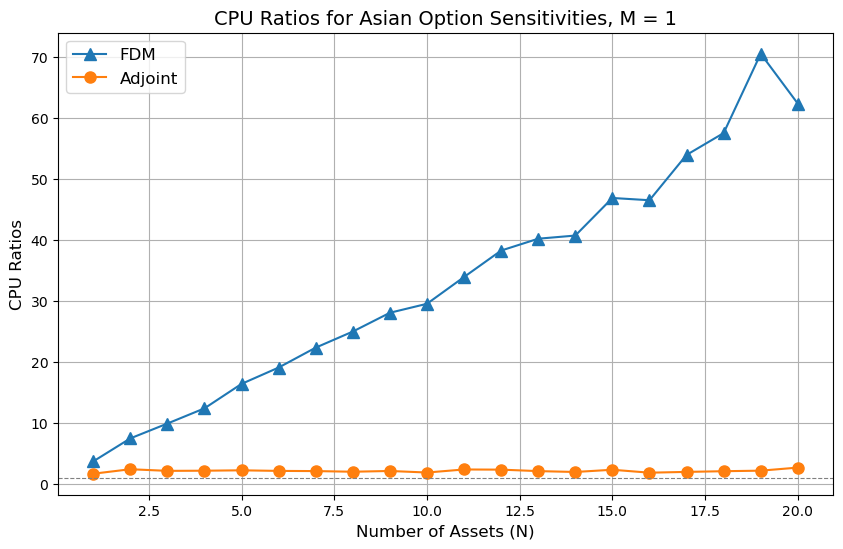

In [8]:
# Timing ratios for functions
Ns = range(1, 21)
ratios_fdm = []
ratios_adjoint = []
iterations = 100
num_paths = 1000

for N in Ns:
    print(f"Simulating {N} assets...")
    
    S0, dividends, vols = gen_input(n= N, M = 1)
    
    # Measure time for payout
    start = time.perf_counter()
    for i in range(iterations):
        MC_Asian(S0, dividends, vols, K, r, T, num_paths)
    time_payout = time.perf_counter() - start
    
    # Measure time for FDM
    start = time.perf_counter()
    for i in range(iterations):
        FDM(S0, dividends, vols, K, r, T, num_paths, 1e-10)
    time_fdm = time.perf_counter() - start
    ratios_fdm.append(time_fdm / time_payout)

    
    # Measure time for adjoint
    start = time.perf_counter()
    for i in range(iterations):
        MC_Asian_AAD(S0, dividends, vols, K, r, T, num_paths)
    time_adjoint = time.perf_counter() - start
    ratios_adjoint.append(time_adjoint / time_payout)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Ns, ratios_fdm, '^-', label='FDM', markersize=8)
plt.plot(Ns, ratios_adjoint, 'o-', label='Adjoint', markersize=8)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
plt.title('CPU Ratios for Asian Option Sensitivities, M = 1', fontsize=14)
plt.xlabel('Number of Assets (N)', fontsize=12)
plt.ylabel('CPU Ratios', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True) 
plt.savefig('CPU Ratios Fix M',bbox_inches="tight")
plt.show()

In [9]:
print(max(ratios_adjoint))

2.7374558437638328


#### Fix N = 1, let M = 1 to 20

Simulating M = 1...
Simulating M = 2...
Simulating M = 3...
Simulating M = 4...
Simulating M = 5...
Simulating M = 6...
Simulating M = 7...
Simulating M = 8...
Simulating M = 9...
Simulating M = 10...
Simulating M = 11...
Simulating M = 12...
Simulating M = 13...
Simulating M = 14...
Simulating M = 15...
Simulating M = 16...
Simulating M = 17...
Simulating M = 18...
Simulating M = 19...
Simulating M = 20...


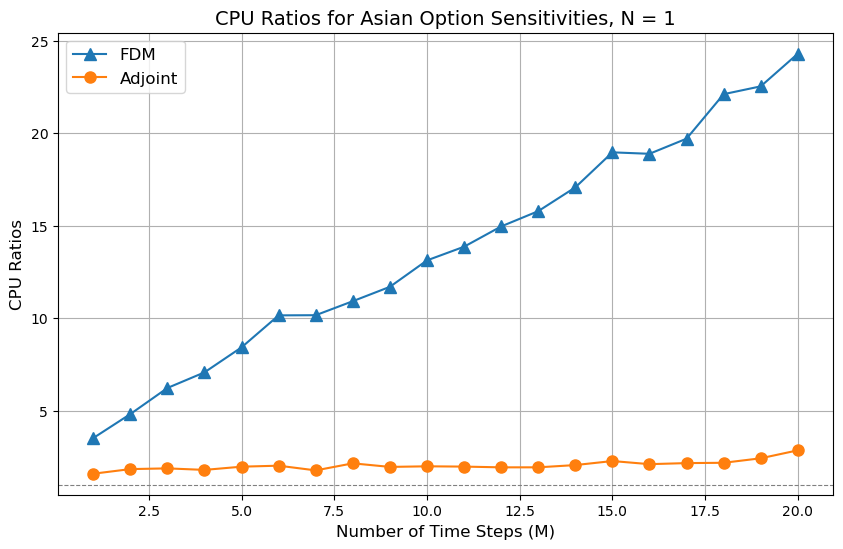

In [10]:
# Timing ratios for functions
Ms = range(1, 21)
ratios_fdm = []
ratios_adjoint = []
iterations = 100

for M in Ms:
    print(f"Simulating M = {M}...")    
    S0, dividends, vols = gen_input(n = 1, M = M)
    
    # Measure time for payout
    start = time.perf_counter()
    for i in range(iterations):
        MC_Asian(S0, dividends, vols, K, r, T, num_paths)
    time_payout = time.perf_counter() - start
    
    # Measure time for FDM
    start = time.perf_counter()
    for i in range(iterations):
        FDM(S0, dividends, vols, K, r, T, num_paths, 1e-10)
    time_fdm = time.perf_counter() - start
    ratios_fdm.append(time_fdm / time_payout)

    
    # Measure time for adjoint
    start = time.perf_counter()
    for i in range(iterations):
        MC_Asian_AAD(S0, dividends, vols, K, r, T, num_paths)
    time_adjoint = time.perf_counter() - start
    ratios_adjoint.append(time_adjoint / time_payout)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Ns, ratios_fdm, '^-', label='FDM', markersize=8)
plt.plot(Ns, ratios_adjoint, 'o-', label='Adjoint', markersize=8)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
plt.title('CPU Ratios for Asian Option Sensitivities, N = 1', fontsize=14)
plt.xlabel('Number of Time Steps (M)', fontsize=12)
plt.ylabel('CPU Ratios', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('CPU Ratios Fix N',bbox_inches="tight")
plt.show()

In [11]:
print(max(ratios_adjoint))

2.862109461032825


#### In both cases, we see that that CPU ratio for the adjoint method is roughly constant and  bounded below 4.